# Lab 4 - Part D: Face detection with logistic regression
The goal of this part of the practical is to implement logistic regression for classifying faces and non-faces. 

**TO DO:** This is a complete working bit of code. Your goals are to:
1. Look at the code and understand it
2. Investigate what happens as you increase the amount of training data - try 750, 1000, 1500, 2000, 3000, 4000 examples.  Does it generalize better?
3. Try learning with gradient descent with 4000 examples. What happens?
4. Convert this to a non-linear logistic regression algorithm by transforming the data before running the routine (see the '`transform`' method of the '`LogisticRegression`' class). Write a routine to transform each data point to a 500x1  vector by evaluating it against 500 radial basis functions.  

    The centers of these functions can be the first 500 data points.  You should experiment with the standard deviation, but somewhere in the range 1-100 should be a good start.
    
    **Note:** since this non-linear model will be largely the same as the linear version, you may want to create a sub-class that inherits from '`LogisticRegression`', and only overrides the '`transform`' method.

### Import modules

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib inline
import numpy as np
from scipy.io import loadmat
from scipy.special import expit as sigmoid

from functions import LogisticRegressionNLL
from optimisation import SteepestDescent, NewtonMethod, optimise
from utils import add_bias, visualise_faces

# Create data loader

In [2]:
class DataLoader:
    def __init__(self, filename):
        self.data = loadmat(filename)
        self.training_images = self.data['x'].transpose(2, 0, 1).astype(np.float32) / 256
        self.training_labels = self.data['y'].squeeze()
        self.testing_images = self.data['xTest'].transpose(2, 0, 1).astype(np.float32) / 256
        self.testing_labels = self.data['yTest'].squeeze()

    def training(self, num_examples=None):
        return self.training_images[slice(num_examples)], self.training_labels[slice(num_examples)]

    def testing(self, num_examples=None):
        return self.testing_images[slice(num_examples)], self.testing_labels[slice(num_examples)]

# Define logistic regression model

In [167]:
class LogisticRegression:
    def __init__(self, dimensions):
        self.phi = add_bias(1e-4 * np.random.randn(dimensions, 1))

    def transform(self, image):
        return add_bias(image.flatten())

    def __call__(self, images):
        x = np.stack([self.transform(image) for image in images], axis=1)
        return sigmoid(self.phi.T @ x)

    def train(self, data, max_iterations, optimiser, tolerance=1e-8):
        images, labels = data
        print(images)
        x = np.stack([self.transform(image) for image in images], axis=1)
        phi_opt, _ = optimise(self.phi, tolerance, function=LogisticRegressionNLL(x, labels),
                              optimiser=optimiser, max_iterations=max_iterations)
        self.phi = phi_opt[-1]

# Load and inspect data

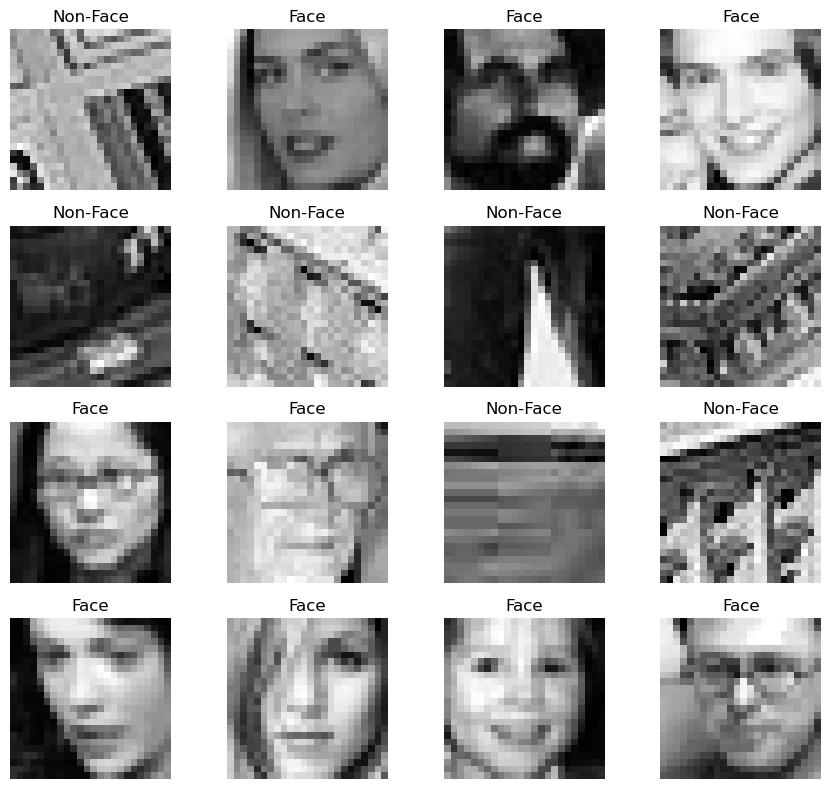

In [3]:
np.random.seed(2)
data = DataLoader('FaceDetectData.mat')

visualise_faces(data.training())

# Train the model
We define the model we are fitting to be logistic regression for 576-dimensional data, i.e. flattened vectors of the 24x24 pixel images. The model is trained using a subset of the training data, and its parameters are updated internally. You can see in the [previous section](#Define-logistic-regression-model) where we defined the model how this is implemented, and verify that it is just an abstraction of what we did in Parts B and C.

In [169]:
model = LogisticRegression(dimensions=24*24)

In [170]:
model.train(data.training(num_examples=8000), max_iterations=50, optimiser=NewtonMethod)

[[[0.47265625 0.52734375 0.54296875 ... 0.54296875 0.62890625 0.66015625]
  [0.42578125 0.5625     0.51953125 ... 0.65625    0.609375   0.52734375]
  [0.44921875 0.53515625 0.5234375  ... 0.3359375  0.3359375  0.390625  ]
  ...
  [0.7265625  0.44140625 0.30859375 ... 0.19140625 0.0546875  0.08203125]
  [0.19921875 0.73046875 0.53515625 ... 0.375      0.05859375 0.09375   ]
  [0.25       0.5234375  0.26171875 ... 0.4453125  0.08203125 0.11328125]]

 [[0.97265625 0.80859375 0.578125   ... 0.71875    0.7265625  0.70703125]
  [0.95703125 0.75390625 0.4453125  ... 0.75       0.7421875  0.7421875 ]
  [0.9296875  0.703125   0.3671875  ... 0.796875   0.765625   0.73046875]
  ...
  [0.75390625 0.61328125 0.54296875 ... 0.37109375 0.515625   0.73828125]
  [0.734375   0.6328125  0.54296875 ... 0.5078125  0.73828125 0.671875  ]
  [0.703125   0.63671875 0.5625     ... 0.6953125  0.65625    0.640625  ]]

 [[0.25390625 0.25       0.33203125 ... 0.25390625 0.25390625 0.25390625]
  [0.234375   0.230468

KeyboardInterrupt: 

# Inference and evaluation
Now that it has been trained, calling the model as a function on images will output the probability of that image being a face or a non-face. This is compared against the ground truth labels for accuracy, and can be visually verified also.

In [ ]:
prediction = model(data.training_images) > 0.5
correct_prediction = prediction == data.training_labels
print('Training Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))

In [ ]:
prediction = model(data.testing_images) > 0.5
correct_prediction = prediction == data.testing_labels
print('Test Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))

visualise_faces((data.testing_images, prediction.squeeze()))

Increase the amount of training data, the change of accuracy on training data and test data:
  
| example_num | train accuracy | test accuracy |
|-------------|----------------|---------------|
| 600         | 76.400%        | 77.600%       |
| 700         | 73.075%        | 69.300%       |
| 1000        | 76.725%        | 75.300%       |
| 1500        | 73.200%        | 74.000%       |
| 2000        | 76.675%        | 76.700%       |
| 3000        | 76.300%        | 76.900%       |
| 4000        | 70.775%        | 72.800%       |
  
When learning with 4000 examples, the accuracy on both training data and test data decreases

In [64]:
class LogisticRegression_Nonlinear:
    def __init__(self, dimensions):
        self.dimension = dimensions
        self.phi = add_bias(1e-4 * np.random.randn(dimensions, 1))
        self.mus = []
        self.sigma = 1.6
        
    def RBF(self, x, mu, sigma):
        return np.arctan(np.linalg.norm(x - mu) / sigma)

    def transform(self, images):
        self.mus = images[:self.dimension]
        transformed_x = np.zeros((1 + self.dimension, len(images)))
        for i in range(len(images)):
            x = np.array([self.RBF(images[i].flatten(), mu.flatten(), self.sigma) for mu in self.mus]).flatten()
            x = add_bias(x)
            transformed_x[:, i] =  x
        return transformed_x

    def __call__(self, images):
        x = self.transform(images)
        return sigmoid(self.phi.T @ x)

    def train(self, data, max_iterations, optimiser, tolerance=1e-8):
        images, labels = data
        x = self.transform(images)
        phi_opt, _ = optimise(self.phi, tolerance, function=LogisticRegressionNLL(x, labels),
                              optimiser=optimiser, max_iterations=max_iterations)
        self.phi = phi_opt[-1]

In [65]:
model = LogisticRegression_Nonlinear(dimensions=500)

In [66]:
model.train(data.training(num_examples=3000), max_iterations=50, optimiser=NewtonMethod)

Iteration    1, Function 2368.3582975871495
Iteration    2, Function 2356.5070395290513
Iteration    3, Function 2353.6028327737886
Iteration    4, Function 2315.285331162562
Iteration    5, Function 2214.4200486162767
Iteration    6, Function 2198.6206804272533
Iteration    7, Function 2197.0519246465337
Iteration    8, Function 2098.8247724321004
Iteration    9, Function 2054.6652049589175
Iteration   10, Function 2035.6806446666533
Iteration   11, Function 2035.1139707151988
Iteration   12, Function 1863.007938684455
Iteration   13, Function 1811.633995564203
Iteration   14, Function 1805.7338244497382
Iteration   15, Function 1794.432335864948
Iteration   16, Function 1791.4648697786631
Iteration   17, Function 1786.0025310747023
Iteration   18, Function 1779.4598315474834
Iteration   19, Function 1772.2803591386341
Iteration   20, Function 1771.541539718517
Iteration   21, Function 1761.2180678320722
Iteration   22, Function 1761.1895105913886
Iteration   23, Function 1760.9004525

In [67]:
prediction = model(data.training_images) > 0.5
correct_prediction = prediction == data.training_labels
print('Training Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))

Training Data: Classified 71.388% correct


Test Data: Classified 57.500% correct


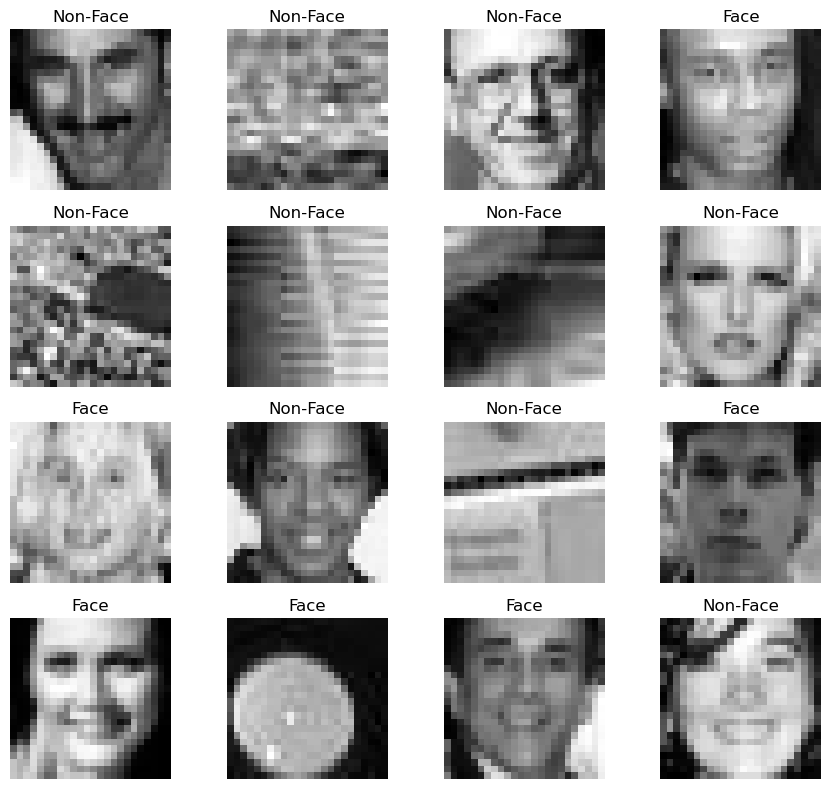

In [68]:
prediction = model(data.testing_images) > 0.5
correct_prediction = prediction == data.testing_labels
print('Test Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))

visualise_faces((data.testing_images, prediction.squeeze()))